# Automação de Reports - HKM Indústria e Comércio
##### O script abaixo executa algumas tarefas repetitíveis que possuem necessidade ao menos semanal. 
##### No geral este código tem como objetivo sincronizar as informações dos arquivos Excel com o banco de dados da empresa, mantendo as informações retiradas do ERP para análises específicas sempre bem atualizadas. 
##### Em alguns arquivos é necessário também gerar um arquivo PDF na rede da empresa e/ou enviar informações por e-mail, como notificações.

### Bibliotecas

In [1]:
from datetime import date, timedelta
import datetime
from dateutil.relativedelta import relativedelta
import time
import csv
import holidays
import win32com.client
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from babel.numbers import format_currency
import sys

### Funções

In [2]:
def automation_reporting(files_infos):
    '''
    Recebe como argumento um dicionário cujas chaves são os nomes das ferramentas, e os valores são
    listas com as informações de cada arquivo na seguinte ordem:
    caminho na rede [0], nome do relatório [1], caminho do relatório [2], e-mails de destino[3],
    título do e-mail[4] e corpo do e-mail[5].
    Caso algum valor seja '', indica que a informação não é necessária para aquele relatório.
    Com essas informações a função abre o arquivo, sincroniza-o com o banco de dados da empresa,
    emite o relatório e o envia por e-mail caso haja necessidade.
    A função ainda documenta o tempo de execução para cada arquivo, alimentando o txt 'runtime_reports'.
    Também emite um e-mail de alerta para mim caso algum erro ocorra.
    '''
    try:
        i = 0
        for key in files_infos.keys():
            start_time = time.time()
            #sincronização do arquivo em excel
            xlapp = win32com.client.DispatchEx("Excel.Application")
            xlapp.Visible = 1
            wb = xlapp.workbooks.open(files_infos.get(key)[0])
            wb.RefreshAll()
            xlapp.CalculateUntilAsyncQueriesDone()
            xlapp.Application.Run('ultimaAtualizacao')
            #se possui nome de relatório definido, gera o mesmo em pdf
            if files_infos.get(key)[1] != '':
                xlapp.Application.Run('impressao')
                wb.ActiveSheet.ExportAsFixedFormat(0, files_infos.get(key)[2])
                xlapp.Application.Run('ClearPrintArea')
            xlapp.DisplayAlerts = False
            wb.Save()
            wb.Close()
            xlapp.Quit()
            #se possui lista de e-mails de destino, abre a instância outlook para dispará-los.
            if files_infos.get(key)[3] != '':
                outlook = win32com.client.Dispatch('Outlook.Application')
                Msg = outlook.CreateItem(0)
                Msg.To = files_infos.get(key)[3]
                Msg.Subject = files_infos.get(key)[4]
                Msg.Body = files_infos.get(key)[5]
                Msg.Attachments.Add(files_infos.get(key)[2])
                Msg.Send()
            end_time = time.time()
            runtime = end_time - start_time
            #documenta as informações de tempo de execução, com nome do arquivo e data.
            with open('runtime_informations.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([list(files_infos.keys())[i], 
                                 datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 
                                 runtime])
            i += 1
    #caso ocorra algum erro, envia um e-mail para mim comunicando o arquivo e a causa do erro
    except Exception as e:
        error_name = type(e).__name__
        outlook = win32com.client.Dispatch('Outlook.Application')
        Msg = outlook.CreateItem(0)
        Msg.To = 'carlos.junior@hkm.ind.br'
        Msg.Subject = 'Erro em execução da automação'
        Msg.Body = 'Ocorreu um erro do tipo ' + error_name + ' durante a execução da automação do arquivo ' + list(files_infos.keys())[i]
        Msg.Send()
    return None
#-----------------------------------------------------------------------

#-----------------------------------------------------------------------
def is_first_business_day():
    '''
    identifica se o dia vigente é o primeiro dia útil do mês.
    é necessário para enviar informações financeiras do mês anterior
    ao invés de tentar enviar o faturamento do mês logo no primeiro dia útil.
    '''
    # lista de feriados do estado do Espírito Santo
    es_holidays = holidays.Brazil(state='ES')
    today = date.today()
    first_day = date(today.year, today.month, 1)
    # se o primeiro dia do mês for um sábado ou domingo, adiciona dias até chegar em um dia útil
    while first_day.weekday() > 4:
        first_day += timedelta(days=1)
    # se o primeiro dia útil for um feriado, adiciona dias até chegar no próximo dia útil
    while first_day in es_holidays:
        first_day += timedelta(days=1)
    return today == first_day

### Parâmetros dos arquivos
##### Utilizados na função automation_reporting()

In [3]:
#arquivos sincronizados toda a segunda-feira
monday_files = {'Acoes de NCs em Aberto': [
                                           'C:\\Users\\carlos.junior\\Desktop\\Dashboards\\Controle acoes de nao conformidades em aberto.lnk',
                                           f'NC_AcoesEmAberto_{date.today().year}-{date.today().month}-{date.today().day}',
                                           f'N:\\12 - Ferramentas de Busca\\Relatorios Semanais\\NC_AcoesEmAberto_{date.today().year}-{date.today().month}-{date.today().day}.pdf',
                                           'carlos.junior@hkm.ind.br;engenharia@hkm.ind.br;pcp@hkm.ind.br;sgq@hkm.ind.br;emerson.carvalho@hkm.ind.br;joao.ganda@hkm.ind.br;saude.ocupacional@hkm.ind.br;nilcelia.ferreira@hkm.ind.br;leonardo.clemente@hkm.ind.br;wilson.silva@hkm.ind.br',
                                           f'Ações em aberto {date.today().day}-{date.today().month}-{date.today().year}',
                                           f'Bom dia,\n\nEm anexo, a relação das ações em aberto das suas respectivas não conformidades.\nEm caso de dúvidas ou sugestões, favor entrar em contato.\n\nEste é um e-mail automático, mas sinta-se livre para respondê-lo.',
                                           ],
                'Flash Report de Nao Conformidade': [
                                           'C:\\Users\\carlos.junior\\Desktop\\Dashboards\\FlashReport_SGQ.lnk',
                                            f'NC_FlashReport_{date.today().year}-{date.today().month}-{date.today().day}',
                                            f'S:\\HKM\\35 - Gestão de Informações\\Gestão de Não Conformidades\\Relatorios\\NC_FlashReport_{date.today().year}-{date.today().month}-{date.today().day}.pdf',
                                            '',
                                            '',
                                            ''
                                            ],
                'Carta Mensal do SGQ': [
                                            'C:\\Users\\carlos.junior\\Desktop\\Dashboards\\CartaMensal_SGQ.lnk',
                                            f'NC_CartaMensal_{date.today().year}-{date.today().month}-{date.today().day}',
                                            f'S:\\HKM\\35 - Gestão de Informações\\Gestão de Não Conformidades\\Relatorios\\NC_CartaMensal_{date.today().year}-{date.today().month}-{date.today().day}.pdf',
                                            '',
                                            '',
                                            ''
                                            ],
                'Nao Conformidades Abertas': [
                                           'C:\\Users\\carlos.junior\\Desktop\\Dashboards\\NaoConformidadesAbertas.lnk',
                                           f'NC_Abertas_{date.today().year}-{date.today().month}-{date.today().day}',
                                           f'S:\\HKM\\35 - Gestão de Informações\\Gestão de Não Conformidades\\Relatorios\\NC_Abertas_{date.today().year}-{date.today().month}-{date.today().day}.pdf',
                                           'sgq@hkm.ind.br',
                                           f'Não Conformidades Abertas {date.today().day}-{date.today().month}-{date.today().year}',
                                           f'Bom dia, SGQ!\n\nEm anexo, as não conformidades abertas no sistema.\nEm caso de dúvidas ou sugestões, favor entrar em contato.\n\nEste é um e-mail automático, mas sinta-se livre para respondê-lo.',
                                           ]
               }

#arquivos sincronizados toda a quinta-feira
thursday_files = {'Nao Conformidades Abertas': [
                                           'C:\\Users\\carlos.junior\\Desktop\\Dashboards\\NaoConformidadesAbertas.lnk',
                                           f'NC_Abertas_{date.today().year}-{date.today().month}-{date.today().day}',
                                           f'S:\\HKM\\35 - Gestão de Informações\\Gestão de Não Conformidades\\Relatorios\\NC_Abertas_{date.today().year}-{date.today().month}-{date.today().day}.pdf',
                                           'sgq@hkm.ind.br',
                                           f'Não Conformidades Abertas {date.today().day}-{date.today().month}-{date.today().year}',
                                           f'Bom dia, SGQ!\n\nEm anexo, as não conformidades abertas no sistema.\nEm caso de dúvidas ou sugestões, favor entrar em contato.\n\nEste é um e-mail automático, mas sinta-se livre para respondê-lo.',
                                           ],
                 }

#arquivos sincronizados todos os dias úteis
workweek_files = {'Aderencia ao Custo Orcado': [
                                           'C:\\Users\\carlos.junior\\Desktop\\Dashboards\\Aderencia_Orcado.lnk',
                                            '',
                                            '',
                                            '',
                                            '',
                                            ''
                                            ],
                'Controle de Solicitacao Compra e Recebimento': [
                                            'C:\\Users\\carlos.junior\\Desktop\\Dashboards\\Controle solicitacao-compra-recebimento.lnk',
                                            '',
                                            '',
                                            '',
                                            '',
                                            ''
                                            ]
               }

### Execução das funções

In [4]:
#caso seja segunda-feira
if date.today().weekday() == 0:
    automation_reporting(monday_files)

#caso seja quinta-feira
if date.today().weekday() == 3:
    automation_reporting(thursday_files)
    
#caso seja algum dia entre segunda e sexta
if date.today().weekday() >= 0 and date.today().weekday() <= 4:
    automation_reporting(workweek_files)

## Códigos ainda não otimizados:
##### A partir daqui, os códigos ainda não foram adaptados às funções acima. Estou modificando-os aos poucos e documentando para uma estrutura menos amadora

#### Report diário de faturamento
##### Diáriamente este script sincroniza um arquivo Excel com gráfico de faturamento e exibe as relações de nota fiscal por projeto com gráfico em anexo via e-mail. 

In [5]:
#REPORT DIÁRIO DE FATURAMENTO
start_time = time.time()

if is_first_business_day():
    first_business_day = date.today() - relativedelta(months=1)
    first_business_day = str(date(first_business_day.year, first_business_day.month, 1))
else:
    first_business_day = date.today()
    first_business_day = str(date(first_business_day.year, first_business_day.month, 1))
    
#------------------------------EXCEL-------------------------------------------------------------------
xlapp = win32com.client.DispatchEx("Excel.Application")
xlapp.Visible = 1
xlapp.DisplayAlerts = False
wb = xlapp.workbooks.open("C:\\Users\\carlos.junior\\Desktop\\FaturamentoDiario\\Faturamento_Diario.xlsm")
xlapp.Application.Run("FiltrosDatasPivots")
wb.RefreshAll()
xlapp.CalculateUntilAsyncQueriesDone()
xlapp.Application.Run("exportpic")
wb.Save()
wb.Close()
xlapp.Quit()
path_to_jpg = "C:\\Users\\carlos.junior\\Desktop\\FaturamentoDiario\\Faturamento.jpg"
#-------------------------------PANDAS-----------------------------------------------------------------
faturamento = pd.read_excel(
    "C:\\Users\\carlos.junior\\Desktop\\FaturamentoDiario\\Faturamento_Diario.xlsm", sheet_name="vwFaturamentoOS")

filtro_data = faturamento[(faturamento['Data de Emissão da NF'] >= first_business_day)]
filtro_data = filtro_data[['OS', 'NF', 'Valor Médio da OS', 'Valor Restante a Faturar', 'Data de Emissão da NF', 'Cliente']]
filtro_data = filtro_data.rename(columns={'Valor Médio da OS': 'Valor da OS'})
filtro_data['NF'] = filtro_data['NF'].astype('int')
faturamento_mensal = filtro_data['Valor da OS'].sum()
faturamento_mensal = "R${:,.2f}".format(faturamento_mensal)
filtro_data["Valor da OS"] = filtro_data["Valor da OS"].apply(lambda x: format_currency(x, currency="BRL", locale="pt_BR"))
filtro_data["Valor Restante a Faturar"] = filtro_data["Valor Restante a Faturar"].apply(lambda x: format_currency(x, currency="BRL", locale="pt_BR"))
df_filtro_data = pd.DataFrame(filtro_data)
df_filtro_data
body_filtro_data = '<html><body>' + df_filtro_data.to_html() + '</body></html>'
# # -----------------------------OUTLOOK----------------------------------------------------------------
outlook = win32com.client.Dispatch("Outlook.Application")
Msg = outlook.CreateItem(0)
Msg.To = 'renata.gava@hkm.ind.br;thiago.pereira@hkm.ind.br;kennedy.alberto@hkm.ind.br;iara.sperandio@hkm.ind.br;eduardo.caser@hkm.ind.br'
#Msg.To = 'carlos.junior@hkm.ind.br'
Msg.Subject = f"Faturamento {date.today().day}-{date.today().month}-{date.today().year}"
Msg.HTMLBody = f'''
 Bom dia,<br><br>
 No presente momento, o faturamento do mês está em {faturamento_mensal}.<br>
 Abaixo, a lista detalhada:<br>
 
 {body_filtro_data}

 Em caso de dúvidas ou sugestões, favor entrar em contato.<br>
 Este é um e-mail automático, mas sinta-se livre para respondê-lo.
 '''
Msg.Attachments.Add(path_to_jpg)
Msg.Send()

end_time = time.time()
runtime = end_time - start_time
with open('runtime_informations.txt', mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Report de Faturamento', 
                    datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 
                    runtime])

#### Report diário de calibração de máquinas de solda
##### Um report automatizado que lê uma planilha de controle de calibração de máquinas de solda e, caso haja alguma máquina com necessidade de calibração, envia um alerta aos interessados.

In [6]:
#REPORT DIÁRIO DE CALIBRAÇÃO DE MÁQUINAS DE SOLDA
start_time = time.time()
df = pd.read_excel(
    "N:/02 - EQUIPE ENGENHARIA/CLODOALDO/Auditoria/BAKER/CALDERARIA/CONTROLE DE FONTES DE SOLDAGEM.xlsx", 
    sheet_name="Plan1")

df.columns = df.iloc[0]
df = df.drop([0])
df = df.set_index(['ITEM'])
df['PRÓXIMA CALIBRAÇÃO'] = pd.to_datetime(df['PRÓXIMA CALIBRAÇÃO'], errors = 'coerce')
df = df.dropna(subset=['PRÓXIMA CALIBRAÇÃO'])

df_late = df[(df['PRÓXIMA CALIBRAÇÃO']<str(datetime.date.today()))]
body_late = '<html><body>' + df_late.to_html() + '</body></html>'

df_next = df[(df['PRÓXIMA CALIBRAÇÃO']>=str(datetime.date.today())) &
            (df['PRÓXIMA CALIBRAÇÃO']<str((datetime.date.today()+relativedelta(days=15))))]
body_next = '<html><body>' + df_next.to_html() + '</body></html>'

body = ''
if len(df_late['TAG']) > 0:
    body += '<br>Máquinas com calibração vencida:<br>'+body_late
if len(df_next['TAG']) > 0:
    body += '<br>Máquinas com vencimento próximo:<br>'+body_next
    
if body != '':
    outlook = win32com.client.Dispatch("Outlook.Application")
    Msg = outlook.CreateItem(0)
    Msg.To = "clodoaldo.santos@hkm.ind.br;mateus.oliveira@hkm.ind.br;ramon.novaes@hkm.ind.br;wilson.silva@hkm.ind.br;reginaldo.barbosa@hkm.ind.br"
    #Msg.To = 'carlos.junior@hkm.ind.br'
    Msg.Subject = "Resumo da Lista de Calibração de Máquinas de Solda"
    Msg.HTMLBody = 'Bom dia!<br>Existem algumas máquinas de solda que precisam de atenção na calibração:<br>'+body
    Msg.Send()
    
end_time = time.time()
runtime = end_time - start_time
with open('runtime_informations.txt', mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Report de Calibracao de Maquinas de Solda', 
                    datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 
                    runtime])
    

C:\Users\carlos.junior\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


#### Notificações de não conformidades atrasadas
##### Alertas para os responsáveis que não atuam nas não conformidades no qual foram solicitados.

In [7]:
#NOTIFICAÇÕES DE NÃO CONFORMIDADES ATRASADAS
start_time = time.time()
xlapp = win32com.client.DispatchEx("Excel.Application")
xlapp.Visible = 1
wb = xlapp.workbooks.open("C:\\Users\\carlos.junior\\Desktop\\Dashboards\\Notificacoes nao conformidades em aberto.lnk")
wb.RefreshAll()
xlapp.CalculateUntilAsyncQueriesDone()
xlapp.DisplayAlerts = False
wb.Save()
wb.Close()
xlapp.Quit()

# #-------------------------------------------------------------------------------------------------
#importando o pandas
import pandas as pd

#primeira tabela: informações dos atrasos

#lendo o arquivo
notificacoes = pd.read_excel(
    "K:/21 - INDICADORES/01 - Indicadores/5_ Indicadores HKM/Notificacoes_RNC.xlsx", sheet_name="acoes atrasadas")

#segunda tabela: lista de e-mails

#lendo a planilha de e-mails
emails = pd.read_excel(
    "K:/21 - INDICADORES/01 - Indicadores/5_ Indicadores HKM/Notificacoes_RNC.xlsx", sheet_name="emails")

#colhendo as informações das colunas em variáveis
emails_responsaveis = emails["Responsável"].values
emails_grau1 = emails["grau1"].values
emails_grau2 = emails["grau2"].values
emails_grau3 = emails["grau3"].values
#emails.tail()

#filtrando os valores com menos de 7 dias de atraso
grau1 = notificacoes[(notificacoes["Dias de Atraso"]>=1) & (notificacoes["Dias de Atraso"]<7)]

#colocando os valores das tabelas em vetores
grau1_Responsavel = grau1["Responsável pela Ação"].values
grau1_Atraso = grau1["Dias de Atraso"].values
grau1_CodNC = grau1["Cód. Não Conf."].values
grau1_NC = grau1["Não Conformidade"].values
grau1_CodOS = grau1["OS"].values
grau1_Descricao = grau1["Descrição"].values
grau1_Cliente = grau1["Cliente"].values
grau1_Familia = grau1["Família"].values
grau1_Tipo = grau1["Tipo"].values
grau1_Fase = grau1["Fase"].values
grau1_Destino = grau1["Destino"].values
grau1_Acao = grau1["Ação"].values
grau1_mensagens = []
emailparaenvio = []
x = len(grau1_CodNC)

if x != 0:
    #para o intervalo do número de itens da matriz
    for i in range(x):
        #filtrar a tabela notificações baseado no e-mail de cada responsável
        notificacoes_filtro = emails[(emails["Responsável"] == grau1_Responsavel[i])]
        #adicionar este e-mail à matriz de emails para envio
        emailparaenvio.append(notificacoes_filtro["grau1"].values)
        #tratando o texto do e-mail para uma string "limpa"
        emailparaenvio[i] = str(emailparaenvio[i]).replace("[","")
        emailparaenvio[i] = str(emailparaenvio[i]).replace("]","")
        emailparaenvio[i] = str(emailparaenvio[i]).replace("'","")
        #adicionar a mensagem para a matriz de mensagens de grau 1
        grau1_mensagens.append(f'''
        Bom dia,

        Na data de hoje, foi constado no sistema de notificações de não-conformidade um atraso nas ações que deveriam ser tomadas.

        Informações do atraso:
            Responsável:{grau1_Responsavel[i]}
            Dias de atraso: {grau1_Atraso[i]}
            Código de não conformidade:{grau1_CodNC[i]}
            Título da NC: {grau1_NC[i]}
            Código da OS:{grau1_CodOS[i]}
            Descrição: {grau1_Descricao[i]}
            Cliente: {grau1_Cliente[i]}
            Família: {grau1_Familia[i]}
            Tipo: {grau1_Tipo[i]}
            Fase: {grau1_Fase[i]}
            Destino: {grau1_Destino[i]}
            Ação: {grau1_Acao[i]}
        
        É possível acessar as informações completas do registro da não conformidade via Software GRV. Para isso, acesse o menu Cadastro -> Qualidade -> Não Conformidade.
            
        Em caso de dúvidas, divergências ou sugestões, favor entrar em contato.
        Este é um e-mail automático, porém sinta-se livre para respondê-lo.

        Att,
        Carlos Alberto Barbosa Junior''')

for email in emailparaenvio:
    if email == '':
        print('Há funcionários de grau 1 sem e-mail cadastrado')
        sys.exit()
        
print(emailparaenvio)

#filtrando os valores entre 7 e 14 dias de atraso
grau2 = notificacoes[(notificacoes["Dias de Atraso"]>=7) & (notificacoes["Dias de Atraso"]<=14)]

#colocando os valores das tabelas em vetores
grau2_Responsavel = grau2["Responsável pela Ação"].values
grau2_Atraso = grau2["Dias de Atraso"].values
grau2_CodNC = grau2["Cód. Não Conf."].values
grau2_NC = grau2["Não Conformidade"].values
grau2_CodOS = grau2["OS"].values
grau2_Descricao = grau2["Descrição"].values
grau2_Cliente = grau2["Cliente"].values
grau2_Familia = grau2["Família"].values
grau2_Tipo = grau2["Tipo"].values
grau2_Fase = grau2["Fase"].values
grau2_Destino = grau2["Destino"].values
grau2_Acao = grau2["Ação"].values
grau2_mensagens = []
grau2_emailparaenvio = []
y = len(grau2_CodNC)

if y != 0:
    #para o intervalo do número de itens da matriz
    for j in range(y):
        #filtrar a tabela notificações baseado no e-mail de cada responsável
        notificacoes_filtro2 = emails[(emails["Responsável"] == grau2_Responsavel[j])]
        #adicionar este e-mail à matriz de emails para envio
        grau2_emailparaenvio.append(notificacoes_filtro2["grau2"].values)
        #tratando o texto do e-mail para uma string "limpa"
        grau2_emailparaenvio[j] = str(grau2_emailparaenvio[j]).replace("[","")
        grau2_emailparaenvio[j] = str(grau2_emailparaenvio[j]).replace("]","")
        grau2_emailparaenvio[j] = str(grau2_emailparaenvio[j]).replace("'","")
        #adicionar a mensagem para a matriz de mensagens de grau 2
        grau2_mensagens.append(f'''
        Bom dia,

        Na data de hoje, foi constado no sistema de notificações de não-conformidade um atraso nas ações que deveriam ser tomadas.

        Informações do atraso:
            Responsável:{grau2_Responsavel[j]}
            Dias de atraso: {grau2_Atraso[j]}
            Código de não conformidade:{grau2_CodNC[j]}
            Título da NC: {grau2_NC[j]}
            Código da OS:{grau2_CodOS[j]}
            Descrição: {grau2_Descricao[j]}
            Cliente: {grau2_Cliente[j]}
            Família: {grau2_Familia[j]}
            Tipo: {grau2_Tipo[j]}
            Fase: {grau2_Fase[j]}
            Destino: {grau2_Destino[j]}
            Ação: {grau2_Acao[j]}
        
        É possível acessar as informações completas do registro da não conformidade via Software GRV. Para isso, acesse o menu Cadastro -> Qualidade -> Não Conformidade.
            
        Em caso de dúvidas, divergências ou sugestões, favor entrar em contato.
        Este é um e-mail automático, porém sinta-se livre para respondê-lo.

        Att,
        Carlos Alberto Barbosa Junior''')
        
for email2 in grau2_emailparaenvio:
    if email2 == '':
        print('Há funcionários de grau 2 sem e-mail cadastrado')
        sys.exit()
        
print(grau2_emailparaenvio)

#filtrando os valores acima de 14 dias de atraso
grau3 = notificacoes[notificacoes["Dias de Atraso"]>14]

#colocando os valores das tabelas em vetores
grau3_Responsavel = grau3["Responsável pela Ação"].values
grau3_Atraso = grau3["Dias de Atraso"].values
grau3_CodNC = grau3["Cód. Não Conf."].values
grau3_NC = grau3["Não Conformidade"].values
grau3_CodOS = grau3["OS"].values
grau3_Descricao = grau3["Descrição"].values
grau3_Cliente = grau3["Cliente"].values
grau3_Familia = grau3["Família"].values
grau3_Tipo = grau3["Tipo"].values
grau3_Fase = grau3["Fase"].values
grau3_Destino = grau3["Destino"].values
grau3_Acao = grau3["Ação"].values
grau3_mensagens = []
grau3_emailparaenvio = []
z = len(grau3_CodNC)

if z != 0:
    #para o intervalo do número de itens da matriz
    for k in range(z):
        #filtrar a tabela notificações baseado no e-mail de cada responsável
        notificacoes_filtro3 = emails[(emails["Responsável"] == grau3_Responsavel[k])]
        #adicionar este e-mail à matriz de emails para envio
        grau3_emailparaenvio.append(notificacoes_filtro3["grau3"].values)
        #tratando o texto do e-mail para uma string "limpa"
        grau3_emailparaenvio[k] = str(grau3_emailparaenvio[k]).replace("[","")
        grau3_emailparaenvio[k] = str(grau3_emailparaenvio[k]).replace("]","")
        grau3_emailparaenvio[k] = str(grau3_emailparaenvio[k]).replace("'","")
        #adicionar a mensagem para a matriz de mensagens de grau 3
        grau3_mensagens.append(f'''
        Bom dia,

        Na data de hoje, foi constado no sistema de notificações de não-conformidade um atraso nas ações que deveriam ser tomadas.

        Informações do atraso:
            Responsável:{grau3_Responsavel[k]}
            Dias de atraso: {grau3_Atraso[k]}
            Código de não conformidade:{grau3_CodNC[k]}
            Título da NC: {grau3_NC[k]}
            Código da OS:{grau3_CodOS[k]}
            Descrição: {grau3_Descricao[k]}
            Cliente: {grau3_Cliente[k]}
            Família: {grau3_Familia[k]}
            Tipo: {grau3_Tipo[k]}
            Fase: {grau3_Fase[k]}
            Destino: {grau3_Destino[k]}
            Ação: {grau3_Acao[k]}
        
        É possível acessar as informações completas do registro da não conformidade via Software GRV. Para isso, acesse o menu Cadastro -> Qualidade -> Não Conformidade.
            
        Em caso de dúvidas, divergências ou sugestões, favor entrar em contato.
        Este é um e-mail automático, porém sinta-se livre para respondê-lo.

        Att,
        Carlos Alberto Barbosa Junior''')
        
for email3 in grau3_emailparaenvio:
    if email3 == '':
        print('Há funcionários de grau 3 sem e-mail cadastrado')
        sys.exit()
        
print(grau3_emailparaenvio)

# #--------------------------------------------------------------------------------------------------------
# enviando os e-mails

# entrando no e-mail
outlook = win32com.client.Dispatch("Outlook.Application")


#laço de repetição para escrever todos os e-mails
if x != 0:
    for i in range (x):
        #abrindo um e-mail novo
        Msg = outlook.CreateItem(0)
        #escrevendo o destinatário
        Msg.To = str(emailparaenvio[i])
        #acessando o campo assunto e escrevendo-o
        Msg.Subject = "Notificação - Grau 1 - Atraso na ação de não-conformidade"
        #acessando o corpo do e-mail e escrevendo-o
        Msg.Body = str(grau1_mensagens[i])
        #enviando o e-mail
        Msg.Send()

if y != 0:
    for j in range (y):
        #abrindo um e-mail novo
        Msg = outlook.CreateItem(0)
        #escrevendo o destinatário
        Msg.To = str(grau2_emailparaenvio[j])
        #acessando o campo assunto e escrevendo-o
        Msg.Subject = "Notificação - Grau 2 - Atraso na ação de não-conformidade"
        #acessando o corpo do e-mail e escrevendo-o
        Msg.Body = str(grau2_mensagens[j])
        #enviando o e-mail
        Msg.Send()
        
if z != 0:
    for k in range (z):
        #abrindo um e-mail novo
        Msg = outlook.CreateItem(0)
        #escrevendo o destinatário
        Msg.To = str(grau3_emailparaenvio[k])
        #acessando o campo assunto e escrevendo-o
        Msg.Subject = "Notificação - Grau 3 - Atraso na ação de não-conformidade"
        #acessando o corpo do e-mail e escrevendo-o
        Msg.Body = str(grau3_mensagens[k])
        #enviando o e-mail
        Msg.Send()
        
end_time = time.time()
runtime = end_time - start_time
with open('runtime_informations.txt', mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Notificacoes de Nao Conformidades', 
                    datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 
                    runtime])

[]
[]
['sgq@hkm.ind.br;renata.gava@hkm.ind.br;thiago.pereira@hkm.ind.br', 'sgq@hkm.ind.br;emerson.carvalho@hkm.ind.br;celio.barros@hkm.ind.br', 'sgq@hkm.ind.br;renata.gava@hkm.ind.br']


### Report de performance de códigos

##### Utiliza as informações do arquivo 'runtime_informations.csv' gerado pelas automações para criar gráficos de análise de desempenho

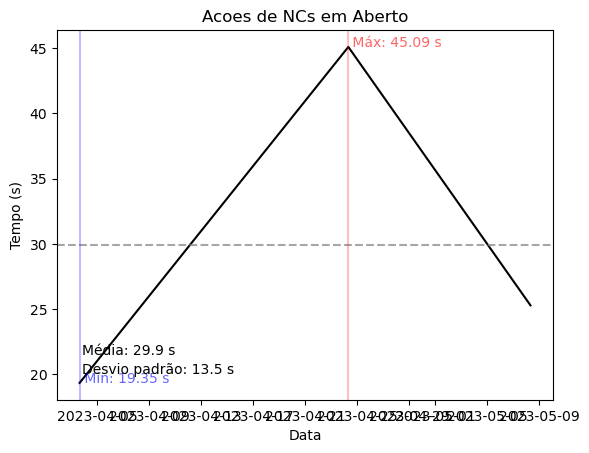

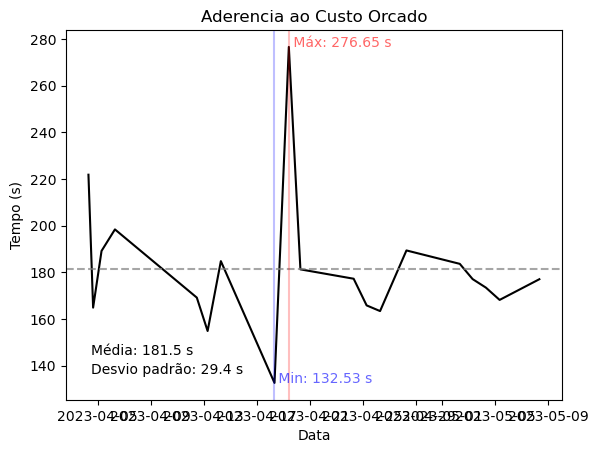

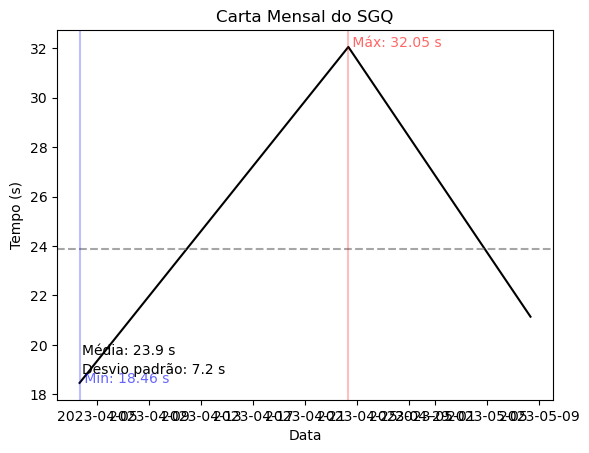

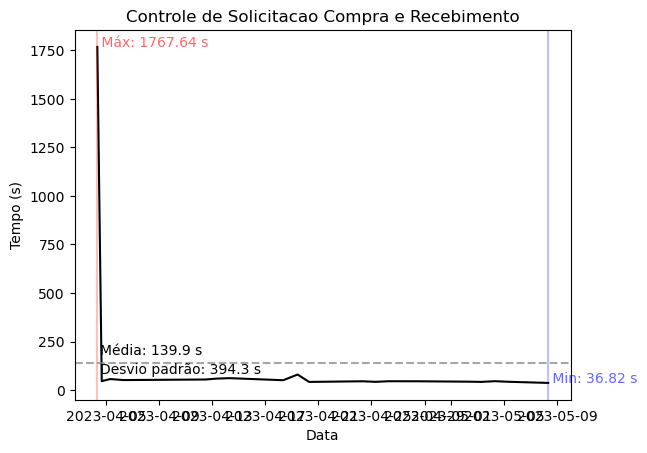

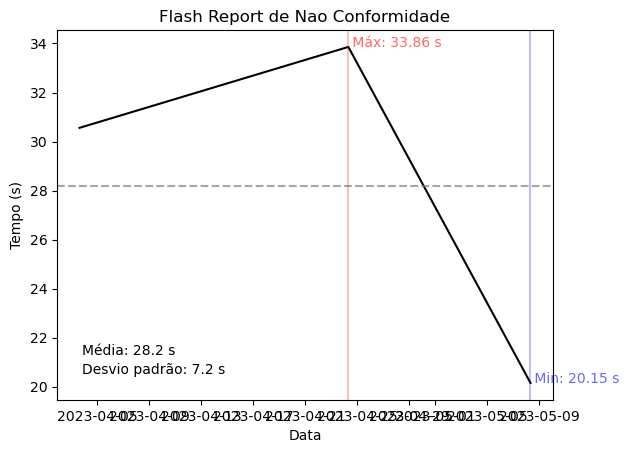

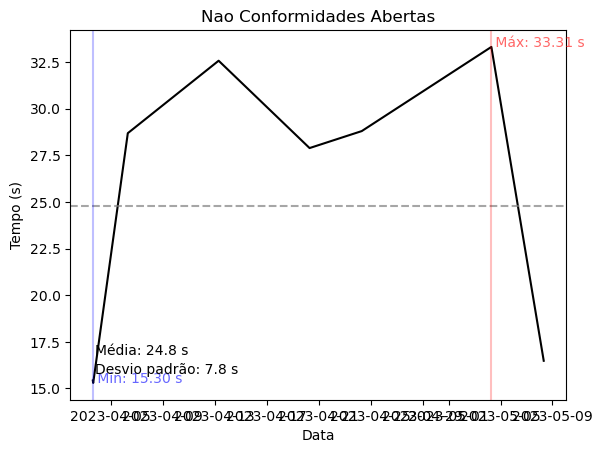

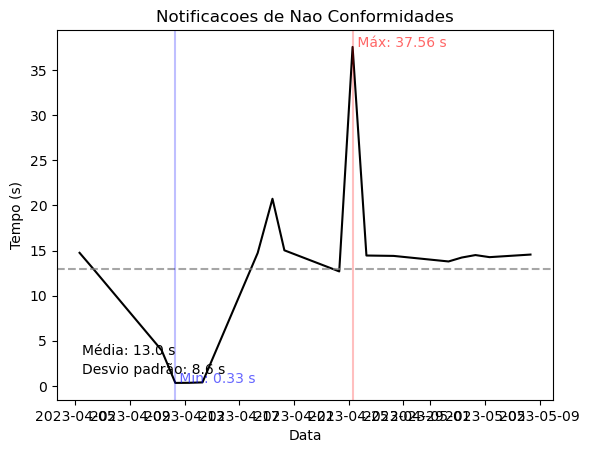

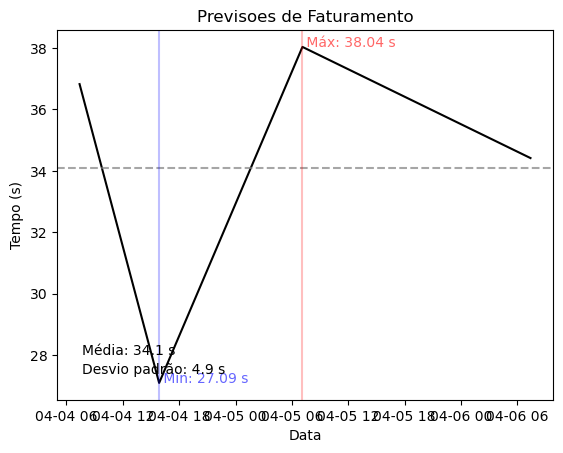

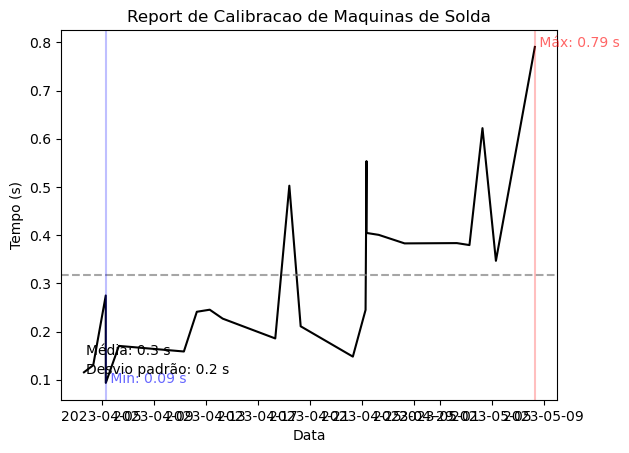

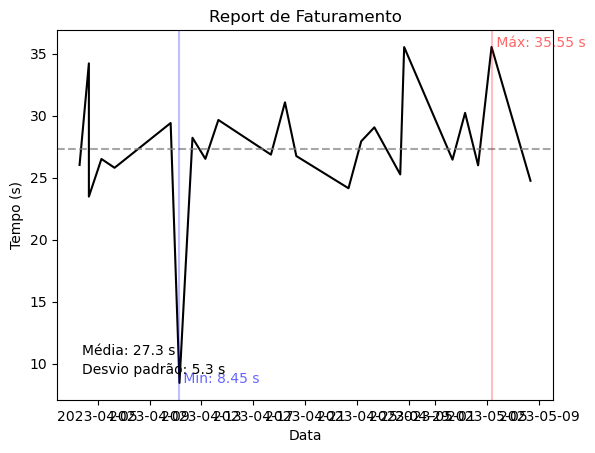

In [8]:
# lendo o arquivo e formatando a coluna de datas
df = pd.read_csv('runtime_informations.txt', encoding='UTF-8')
df['data_execucao'] = pd.to_datetime(df['data_execucao'])
# gerando uma lista com os nomes únicos dos arquivos
files = sorted(list(set(df['nome_arquivo'].tolist())))
# para cada arquivo, monta uma tabela temporária apenas do arquivo com data e tempo de execução.
# além disso gera um gráfico de área com informações de média, desvio padrão, tempo mínimo e máximo
for file in files:
    # tabela temporária para cada nome de arquivo
    table = df.loc[df['nome_arquivo'] == file]
    table = table[['data_execucao', 'tempo']].set_index('data_execucao')
    # variáveis
    x = table.index
    y = table['tempo']
    ymax = np.max(y)
    xmax = x[np.argmax(y)]
    ymin = np.min(y)
    xmin = x[np.argmin(y)]
    # execução do gráfico
    fig, ax = plt.subplots()
    ax.plot(x, y, color='black') #linha principal do gráfico
    ax.axhline(y=table['tempo'].mean(), color='gray', linestyle='--', alpha=0.7) #linha de média
    plt.title(file)
    plt.xlabel('Data')
    plt.ylabel('Tempo (s)')
    ax.axvline(x=xmax, color='r', linestyle='-', alpha=0.25) #linha de valor máximo
    ax.axvline(x=xmin, color='b', linestyle='-', alpha=0.25) #linha de valor mínimo
    ax.text(xmax, ymax, f' Máx: {ymax:.2f} s', fontsize=10, color='r', alpha=0.6) #texto com indicador máximo
    ax.text(xmin, ymin, f' Min: {ymin:.2f} s', fontsize=10, color='b', alpha=0.6) #texto com indicador mínimo
    # informações flutuantes de média e desvio padrão
    plt.text(0.05, 0.15, f"Média: {round(table['tempo'].mean(), 1)} s", transform=plt.gca().transAxes, va='top')
    plt.text(0.05, 0.10, f"Desvio padrão: {round(table['tempo'].std(), 1)} s", transform=plt.gca().transAxes, va='top')
    plt.savefig(f'pic/{file}.png') #salva cada gráfico na pasta pic
    #plt.show()

#enviando os gráficos salvos por e-mail
outlook = win32com.client.Dispatch('Outlook.Application')
Msg = outlook.CreateItem(0)
Msg.To = 'carlos.junior@hkm.ind.br'
Msg.Subject = f'Report de performance das automações {date.today().day}-{date.today().month}-{date.today().year}'
Msg.Body = 'Bom dia!\n\nEm anexo os gráficos de desempenho das automações.'
for file in files:
    Msg.Attachments.Add(f'C:/Users/carlos.junior/Documents/GitHub/python/pic/{file}.png')
Msg.Send()